In [1]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
import bnns.model_configs
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits

/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Adjust as needed
SAMPLE_PATH = "../samples/2025-02-18T14:57:49.021828"
SAMPLE_PATH = SAMPLE_PATH + "/HMC"
SEED = 10

# Load models

In [4]:
models = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-3:] == ".nc":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                print(file_name)
                az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                samples = az_data.to_dict()["posterior"]
                y_loc = samples.pop("y_loc", None)
                models.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "az_data": az_data, "samples": samples, "y_loc": y_loc})
print(f"Loaded {len(models)} models")

UCI_BNN_2_50_17.nc
UCI_BNN_2_50_11.nc
UCI_BNN_2_50_6.nc
UCI_BNN_2_50_12.nc
UCI_BNN_2_50_3.nc
UCI_BNN_2_50_4.nc
UCI_BNN_2_50_13.nc
UCI_BNN_2_50_15.nc
UCI_BNN_2_50_1.nc
UCI_BNN_2_50_14.nc
UCI_BNN_2_50_16.nc
UCI_BNN_2_50_18.nc
UCI_BNN_2_50_19.nc
UCI_BNN_2_50_9.nc
UCI_BNN_2_50_5.nc
UCI_BNN_2_50_10.nc
UCI_BNN_2_50_2.nc
UCI_BNN_2_50_0.nc
UCI_BNN_2_50_8.nc
UCI_BNN_2_50_7.nc
UCI_CBNN_2_50_0.nc
UCI_CBNN_2_50_1.nc
UCI_CBNN_2_50_2.nc
UCI_CBNN_2_50_3.nc
UCI_CBNN_2_50_4.nc
UCI_CBNN_2_50_5.nc
UCI_CBNN_2_50_6.nc
UCI_CBNN_2_50_7.nc
UCI_CBNN_2_50_8.nc
UCI_CBNN_2_50_9.nc
UCI_CBNN_2_50_10.nc
UCI_CBNN_2_50_11.nc
UCI_CBNN_2_50_12.nc
UCI_CBNN_2_50_13.nc
UCI_CBNN_2_50_14.nc
UCI_CBNN_2_50_15.nc
UCI_CBNN_2_50_16.nc
UCI_CBNN_2_50_17.nc
UCI_CBNN_2_50_18.nc
UCI_CBNN_2_50_19.nc
UCI_BNN_2_50_17.nc
UCI_BNN_2_50_11.nc
UCI_BNN_2_50_6.nc
UCI_BNN_2_50_12.nc
UCI_BNN_2_50_3.nc
UCI_BNN_2_50_4.nc
UCI_BNN_2_50_13.nc
UCI_BNN_2_50_15.nc
UCI_BNN_2_50_1.nc
UCI_BNN_2_50_14.nc
UCI_BNN_2_50_16.nc
UCI_BNN_2_50_18.nc
UCI_BNN_2_50_19.

# Compute Negative-Log-Likelihood, RMSE
To compare with Stein paper, Table 2

In [5]:
# From Stein paper, probably more stable but should be equivalent
def nll_reg_fn(posterior_samples, model, x, y, batch_ndims):
    lls = log_likelihood(model, posterior_samples, X=x, y=y, batch_ndims=batch_ndims)["y"]
    return -(jax.scipy.special.logsumexp(lls, axis=0) - jnp.log(lls.shape[0])).mean()

In [ ]:
table = [{"dataset": x["dataset"], "model": x["model"], "split": x["split"]} for x in models]
for row, d in zip(models, table):
    dataset = UCIDataset(d["dataset"])
    splits = load_standard_splits(True)[d["dataset"]]
    samples = row["samples"]
    model = bnns.model_configs.__dict__[row["model"]]
    train_split = splits[d["split"]]["tr"]
    test_split = splits[d["split"]]["te"]

    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:, -1]

    train_X = X[train_split]
    train_y = y[train_split]
    test_X = X[test_split]
    test_y = y[test_split]
    train_nll = -log_likelihood(model, samples, X=train_X, y=train_y.flatten(), batch_ndims=2)["y"]
    # print(test_X.shape, test_y.shape)
    test_nll = -log_likelihood(model, samples, X=test_X, y=test_y.flatten(), batch_ndims=2)["y"]

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=2)
    # print(samples.keys())
    predicted_ys = predictive(model_key, X=train_X, y=None, D_Y=1)["y_loc"]
    train_rmse = jnp.sqrt(((train_y - predicted_ys[0])**2).mean())

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=2)
    predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y_loc"]
    test_rmse = jnp.sqrt(((test_y - predicted_ys[0])**2).mean())

    #d["train_nll"] = train_nll.mean()
    d["train_nll"] = nll_reg_fn(samples, model, train_X, train_y, 2)
    d["test_nll"] = nll_reg_fn(samples, model, test_X, test_y, 2)
    d["train_rmse"] = train_rmse.item()
    d["test_rmse"] = test_rmse.item()
table_df = pd.DataFrame(table)
table_df

In [ ]:
table_df[]

In [7]:
grouped = table_df.groupby(["dataset", "model"]).mean()
stds =  table_df.groupby(["dataset", "model"]).std()[["train_nll", "test_nll", "train_rmse", "test_rmse"]].round(1)
grouped[["train_nll", "test_nll"]] = grouped[["train_nll", "test_nll"]].astype(float).round(1)
grouped[["train_nll", "test_nll", "train_rmse", "test_rmse"]] = grouped[["train_nll", "test_nll", "train_rmse", "test_rmse"]].round(1).astype(str) + "±" + stds.astype(str)
grouped["split"] = table_df.groupby(["dataset", "model"]).count()["split"]
grouped["target_test_nll"] = ["2.2±0.2", "2.2±0.2","2.7±0.3", "2.7±0.3", "0.5±1.5", "0.5±1.5"]
grouped["target_test_rmse"] = ["3.6±0.7","3.6±0.7", "4.7±0.6","4.7±0.6", "0.3±0.1", "0.3±0.1"]
grouped[["split", "train_nll", "test_nll", "target_test_nll", "train_rmse", "test_rmse", "target_test_rmse"]]

split train_nll test_nll target_test_nll  \
dataset        model                                                     
boston-housing UCI_BNN_2_50      20   2.2±0.2  5.2±1.7         2.2±0.2   
               UCI_CBNN_2_50     20   2.3±0.4  6.3±2.7         2.2±0.2   
concrete       UCI_BNN_2_50      20   2.5±0.1  4.0±0.7         2.7±0.3   
               UCI_CBNN_2_50     20   2.6±0.1  4.0±0.6         2.7±0.3   
energy         UCI_BNN_2_50      20   0.9±0.4  1.8±0.9         0.5±1.5   
               UCI_CBNN_2_50     20   0.8±0.3  1.4±0.3         0.5±1.5   

                             train_rmse test_rmse target_test_rmse  
dataset        model                                                
boston-housing UCI_BNN_2_50     1.9±0.2   3.7±0.7          3.6±0.7  
               UCI_CBNN_2_50   13.0±0.2  12.6±1.6          3.6±0.7  
concrete       UCI_BNN_2_50     3.0±0.2   5.1±0.6          4.7±0.6  
               UCI_CBNN_2_50   23.6±0.3  23.0±1.1          4.7±0.6  
energy         UCI_BNN_2_50     0.5±0.1   0.7±0.2          0.3±0.1  
               UCI_CBNN_2_50   14.2±0.1  14.2±0.7          0.3±0.1

# ArviZ posterior predictive check

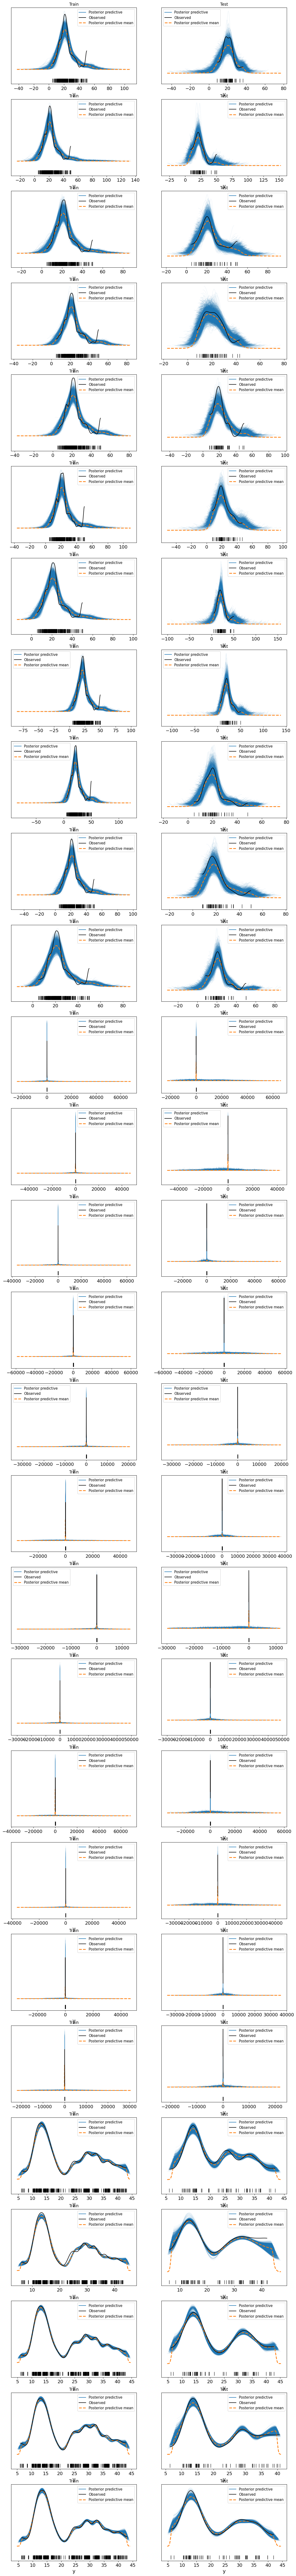

In [12]:
key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, (len(models), 2))
fig, axs = plt.subplots(len(models), 2, figsize=(15, 5*len(models)))
axs = np.array([axs]) if len(models) == 1 else axs
for (key_tr, key_te), d, row in zip(keys, models, range(len(models))):
    model = bnns.model_configs.__dict__[d["model"]]
    predictive = Predictive(model, posterior_samples=d["samples"], return_sites=["y"], batch_ndims=2, parallel=True)
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]

    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:, -1]

    train_X = X[split["tr"]]
    train_y = y[split["tr"]]
    test_X = X[split["te"]]
    test_y = y[split["te"]]
    predictive_ys = predictive(key_tr, X=train_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": train_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": train_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 0], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,0].set_title("Train")

    predictive_ys = predictive(key_te, X=test_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": test_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": test_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 1], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,1].set_title("Test")
    

# Plot similar to NumPyro SteinVI example

DATASET: boston-housing, SPLIT: 17, NLL: 5.104551792144775, RMSE: 2.518686294555664
DATASET: boston-housing, SPLIT: 4, NLL: 6.263476848602295, RMSE: 3.3669373989105225
DATASET: boston-housing, SPLIT: 16, NLL: 5.282326698303223, RMSE: 2.816502094268799
DATASET: boston-housing, SPLIT: 10, NLL: 8.960549354553223, RMSE: 3.0452518463134766
DATASET: boston-housing, SPLIT: 0, NLL: 3.573181390762329, RMSE: 2.358123779296875
DATASET: boston-housing, SPLIT: 5, NLL: 4.327027797698975, RMSE: 1.9282044172286987
DATASET: boston-housing, SPLIT: 10, NLL: 12.391129493713379, RMSE: 3.1013596057891846
DATASET: boston-housing, SPLIT: 15, NLL: 3.4777908325195312, RMSE: 1.8712406158447266
DATASET: energy, SPLIT: 17, NLL: 0.9188492894172668, RMSE: 0.531893253326416
DATASET: energy, SPLIT: 4, NLL: 2.0013163089752197, RMSE: 0.7399341464042664
DATASET: energy, SPLIT: 16, NLL: 1.5309631824493408, RMSE: 0.6936148405075073
DATASET: energy, SPLIT: 10, NLL: 0.9320082068443298, RMSE: 0.4788781702518463
DATASET: energ

/tmp/ipykernel_8071/3651890567.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)


DATASET: concrete, SPLIT: 0, NLL: 4.261728763580322, RMSE: 4.740866661071777
DATASET: concrete, SPLIT: 5, NLL: 4.757241249084473, RMSE: 5.265600681304932
DATASET: concrete, SPLIT: 10, NLL: 3.104306221008301, RMSE: 3.3879268169403076
DATASET: concrete, SPLIT: 15, NLL: 4.975351810455322, RMSE: 5.068652629852295


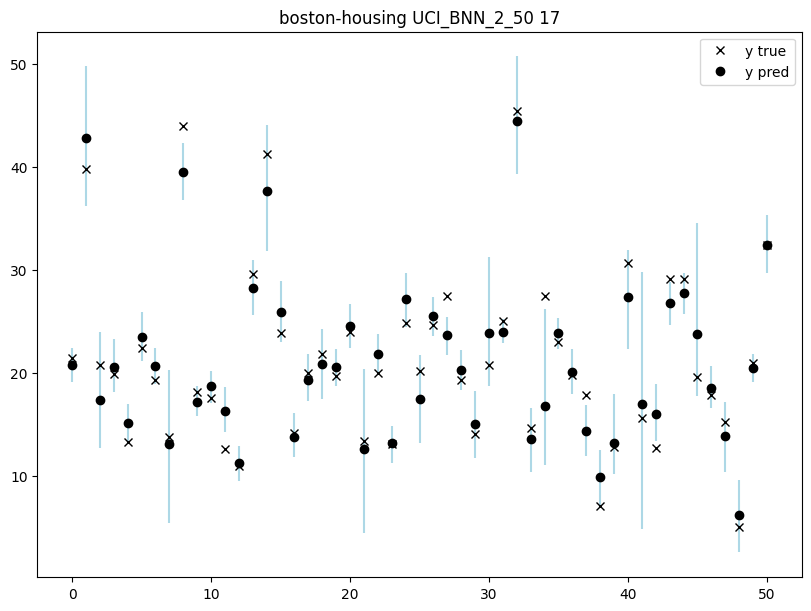

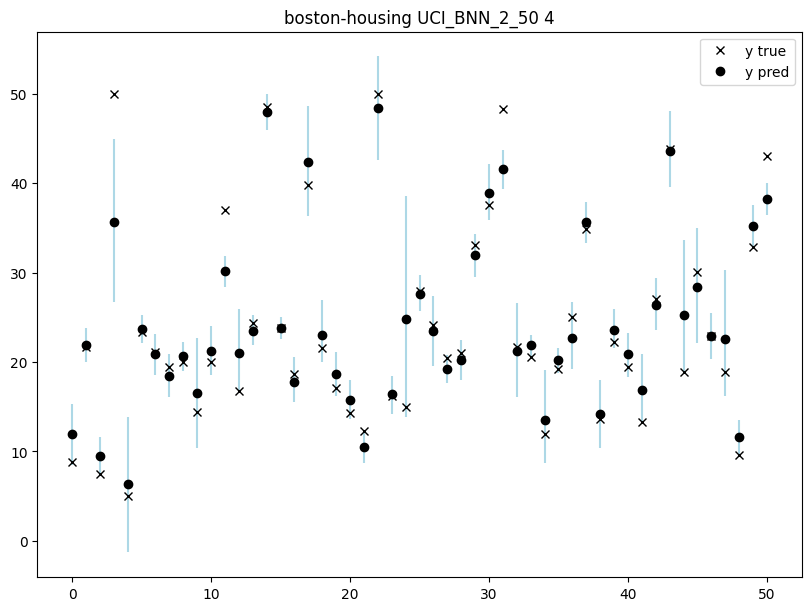

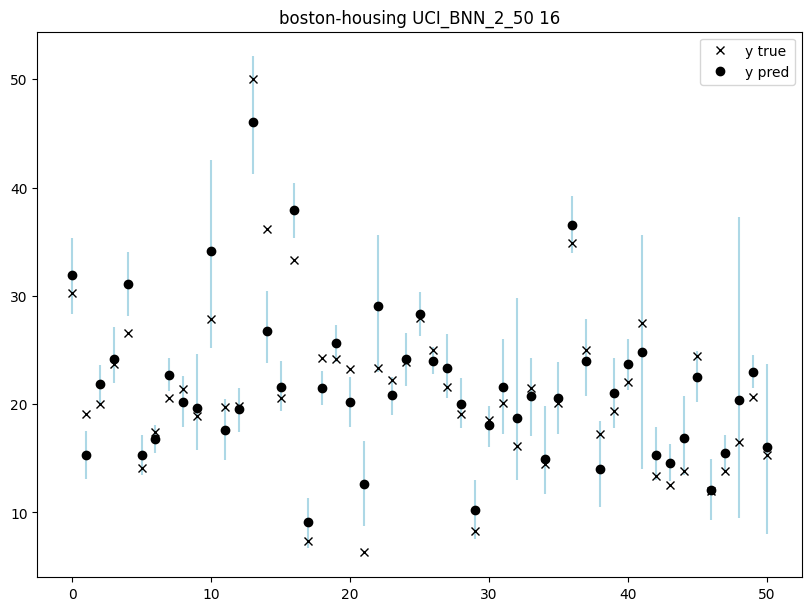

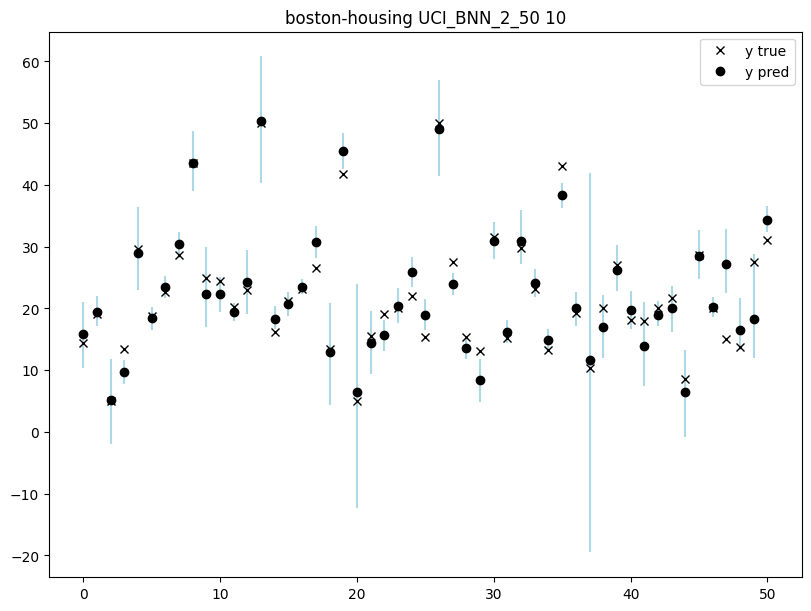

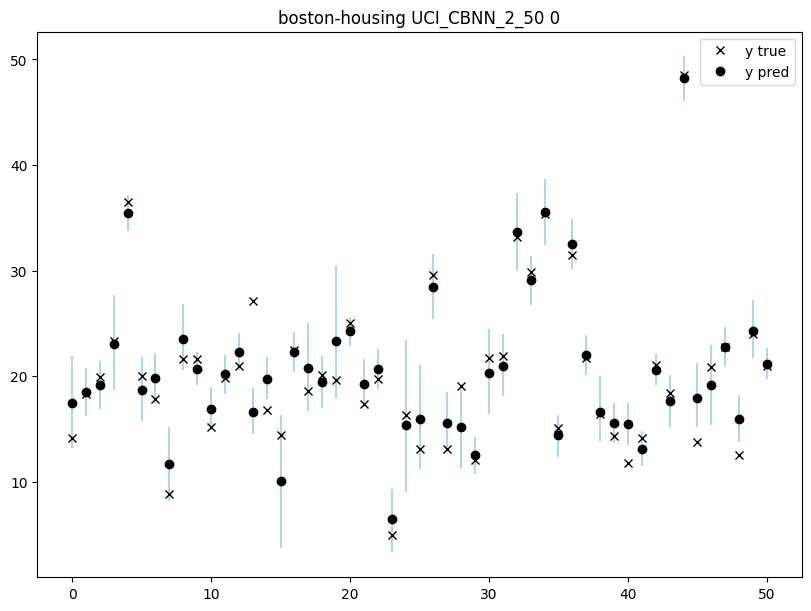

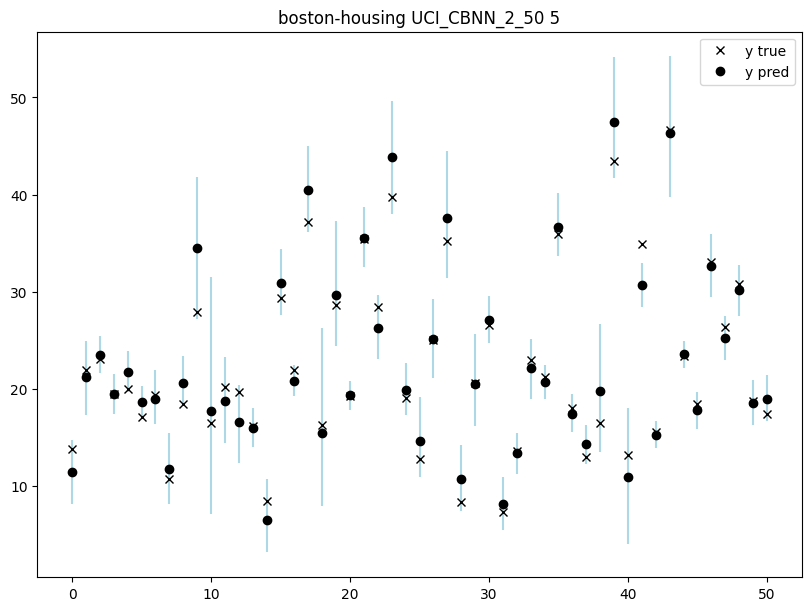

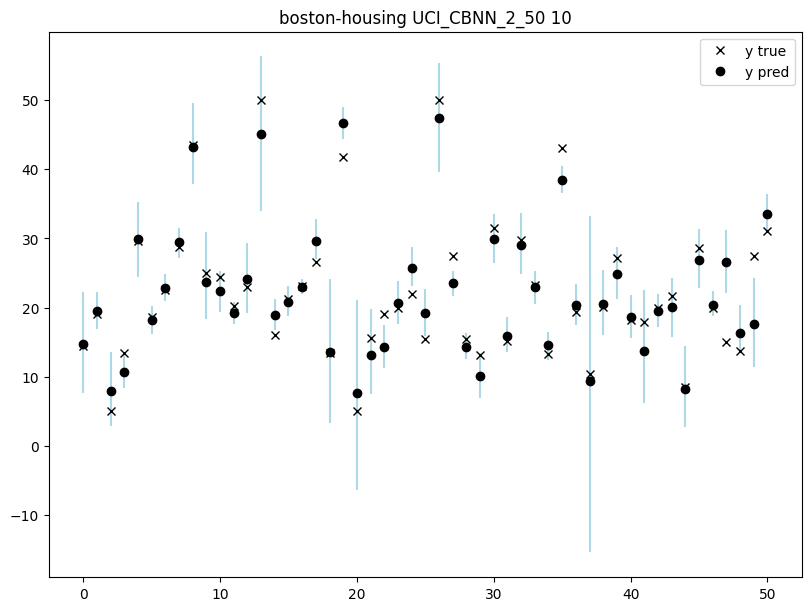

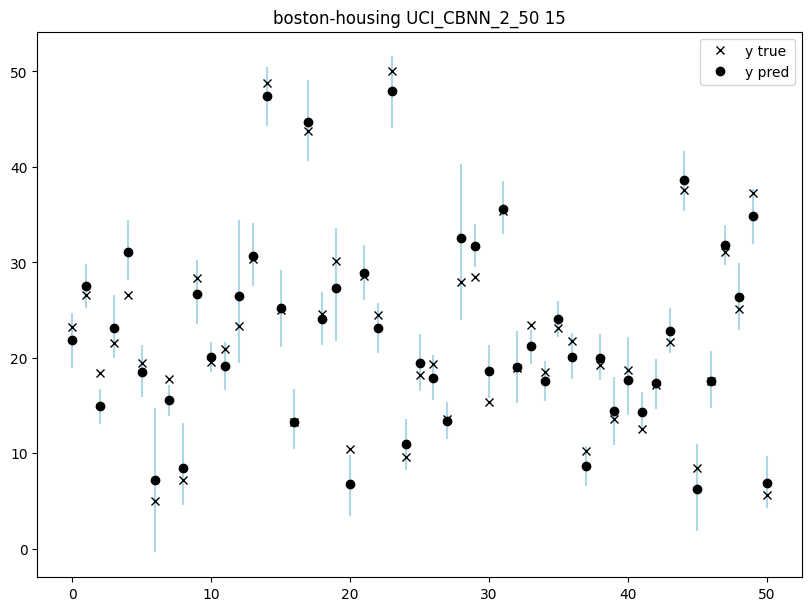

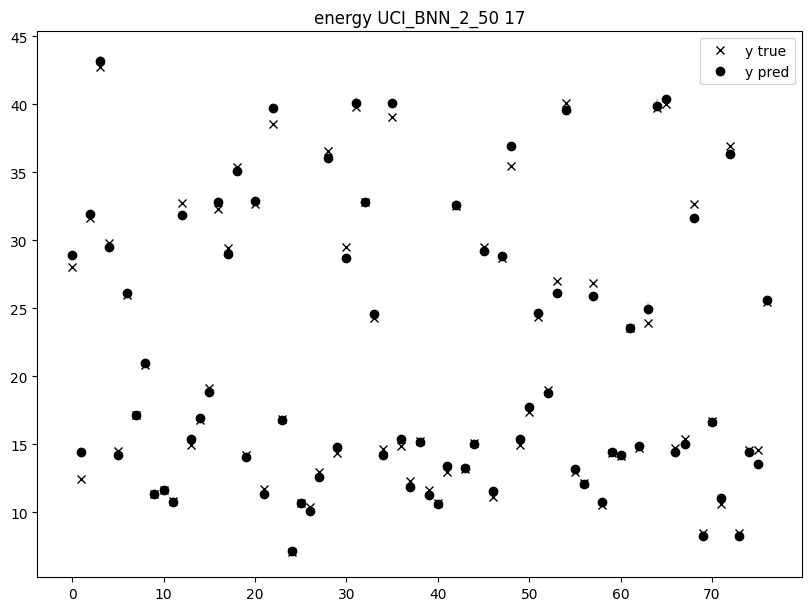

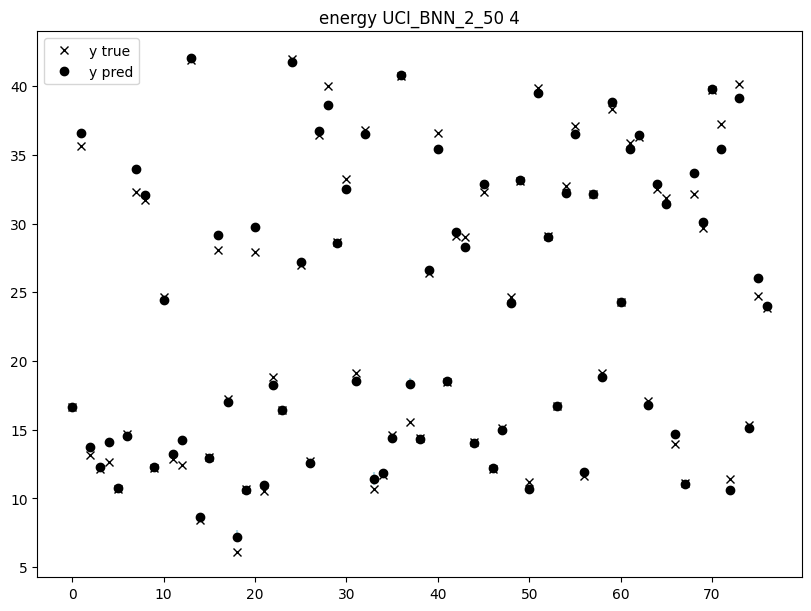

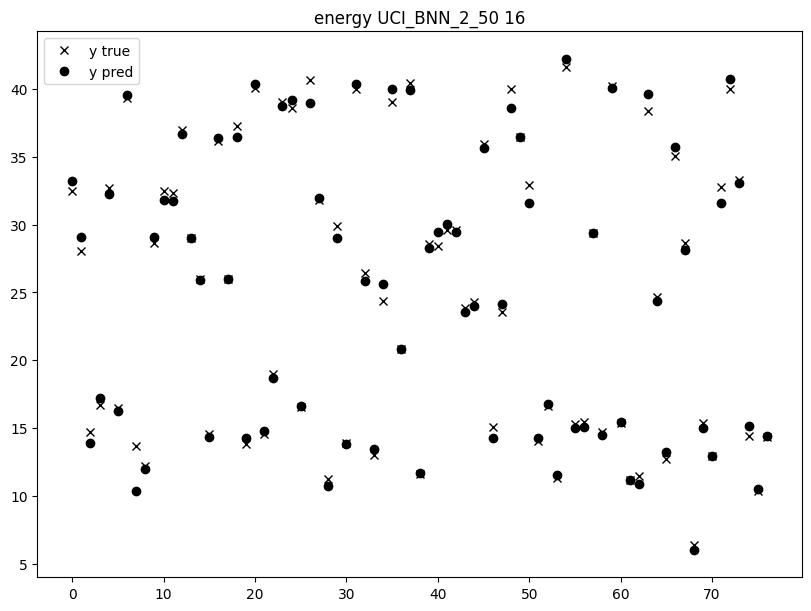

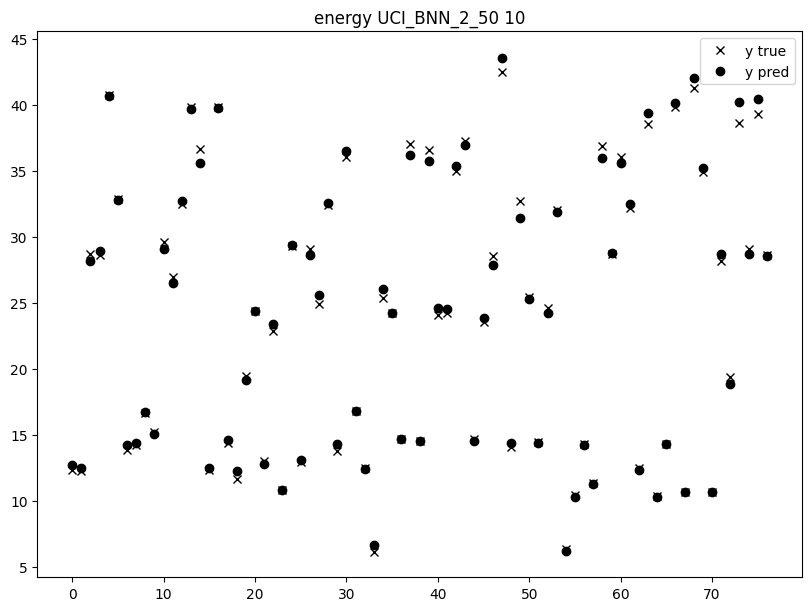

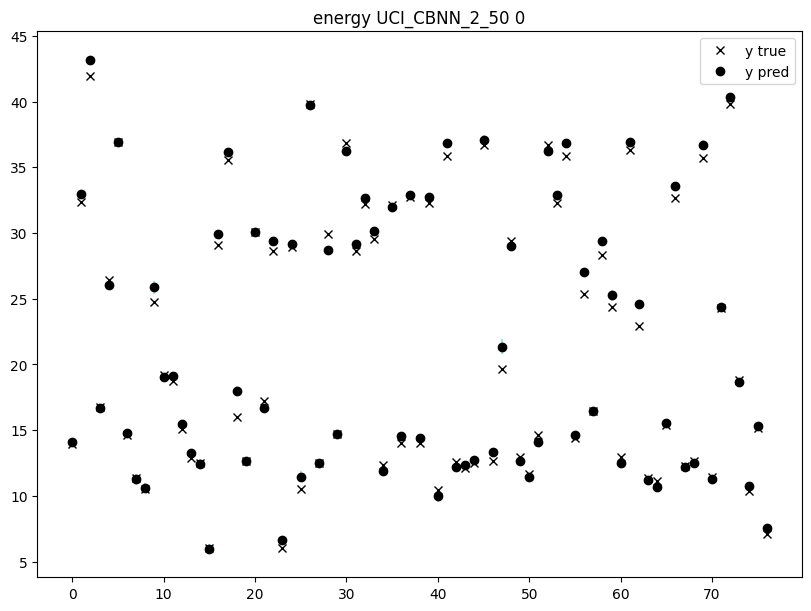

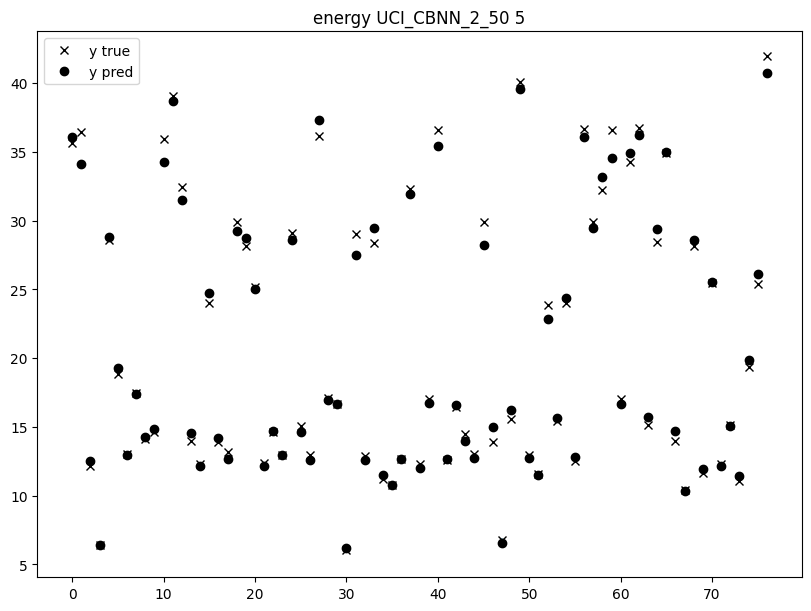

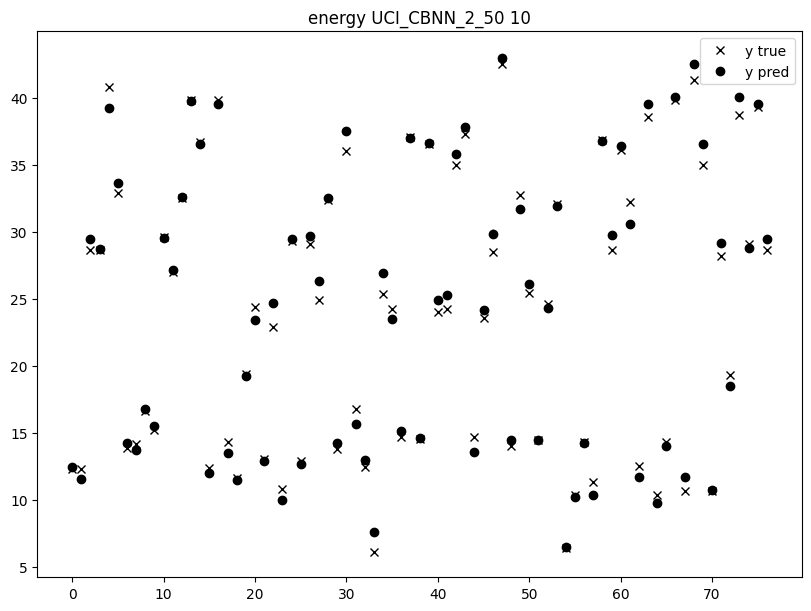

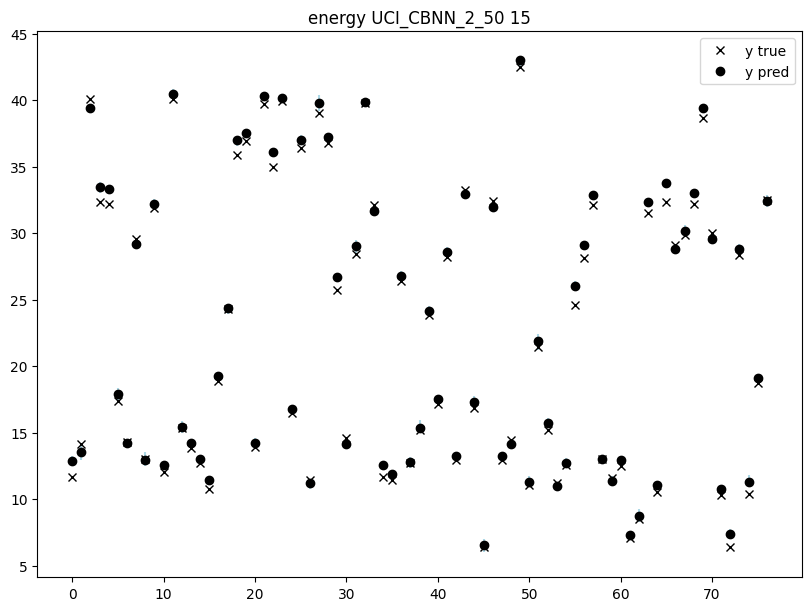

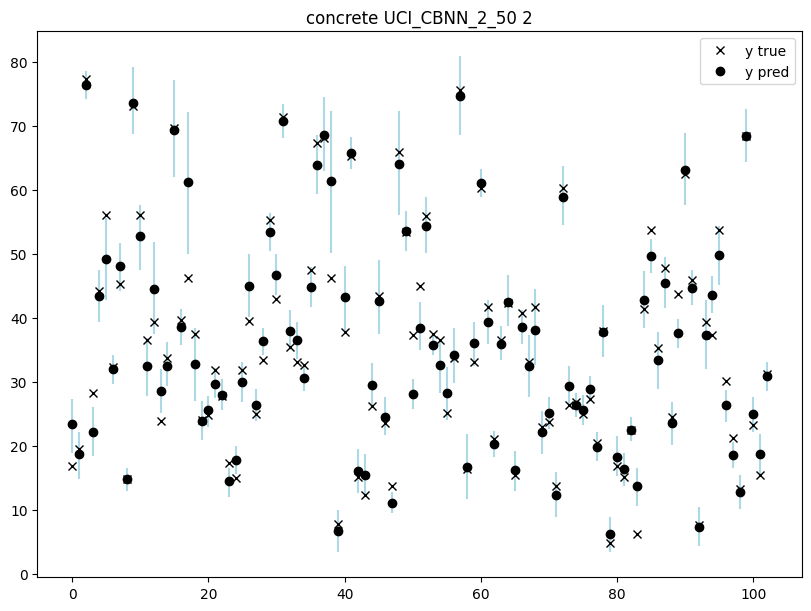

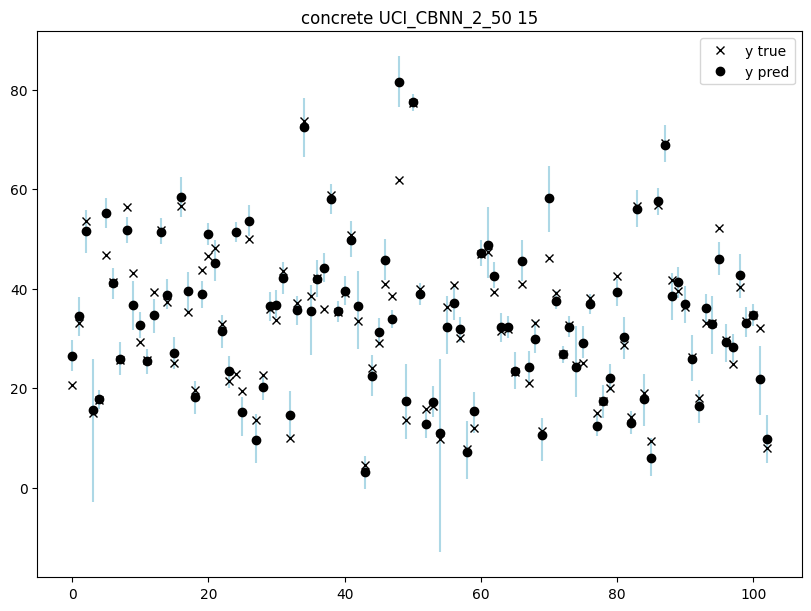

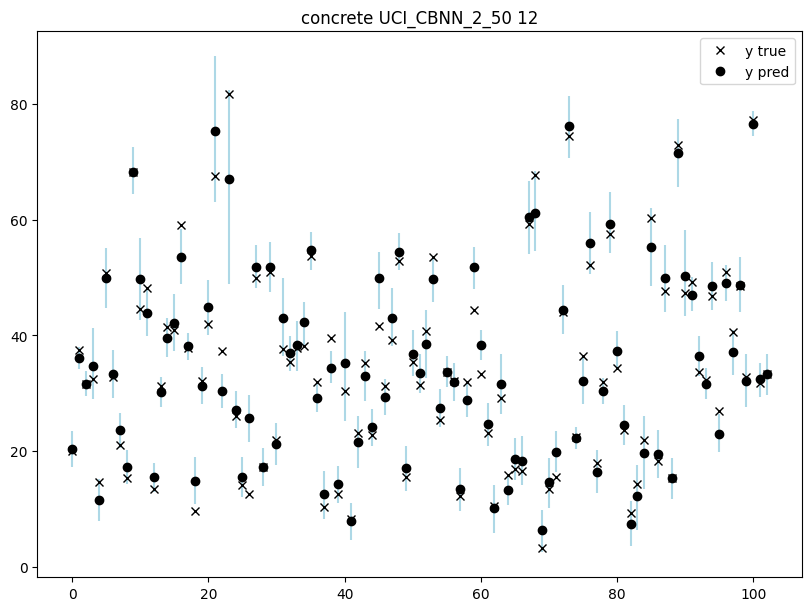

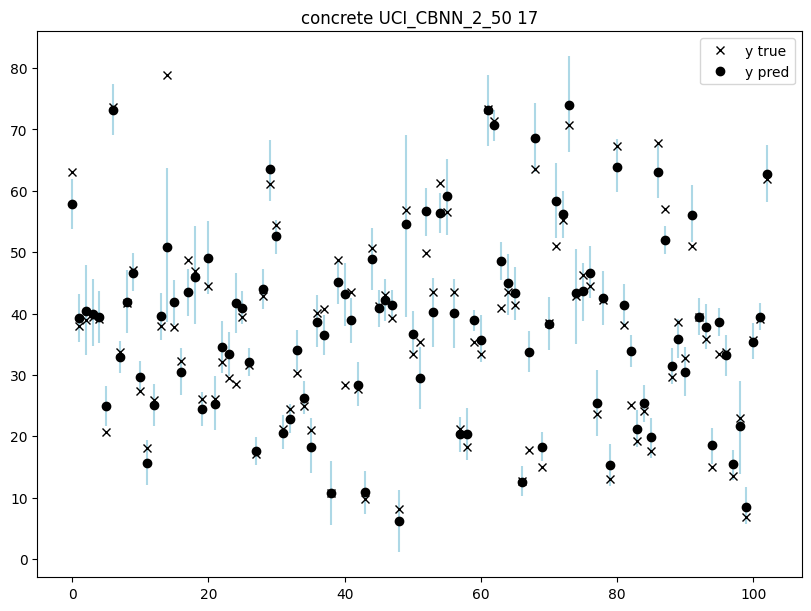

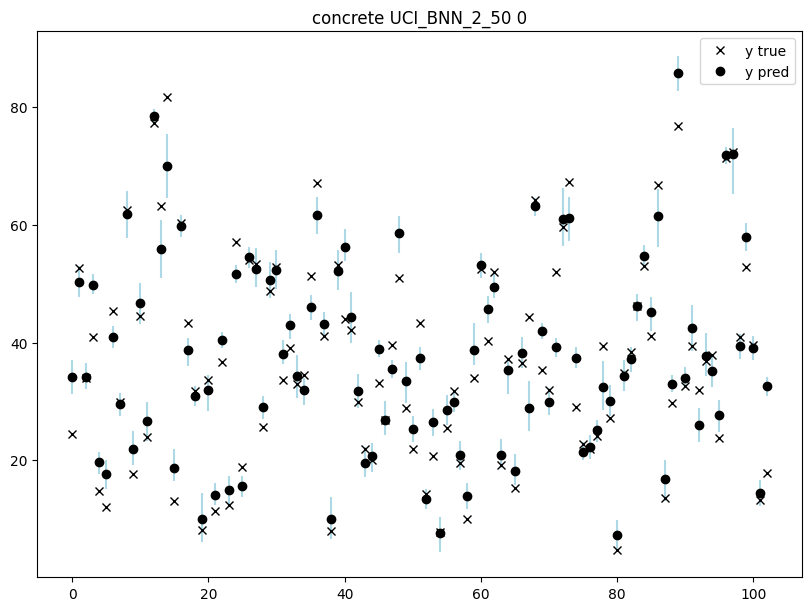

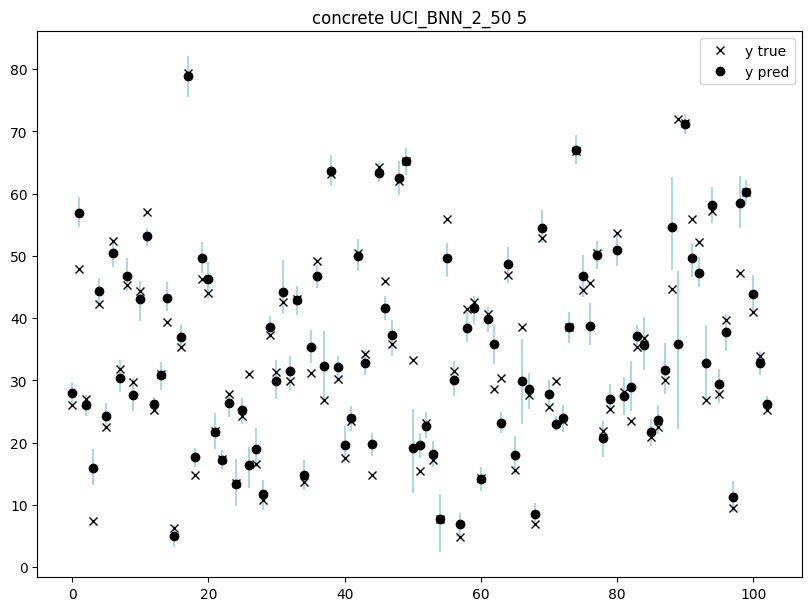

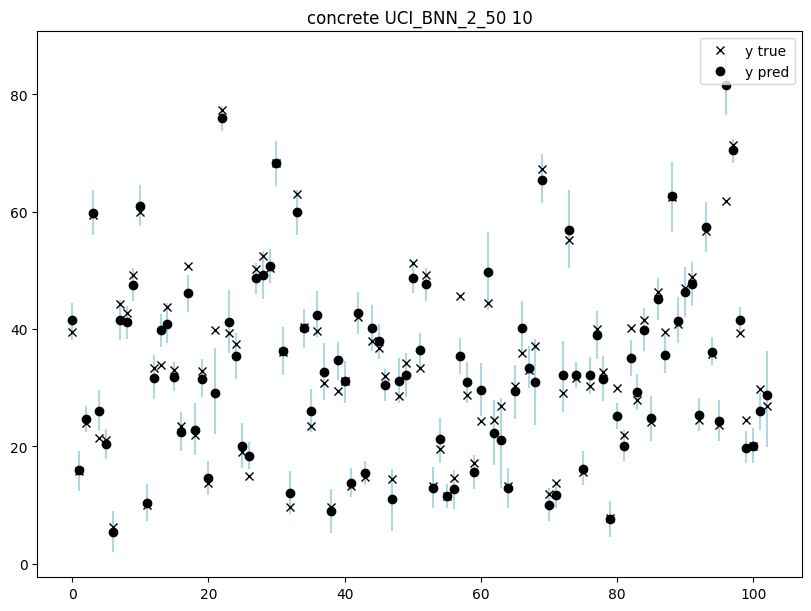

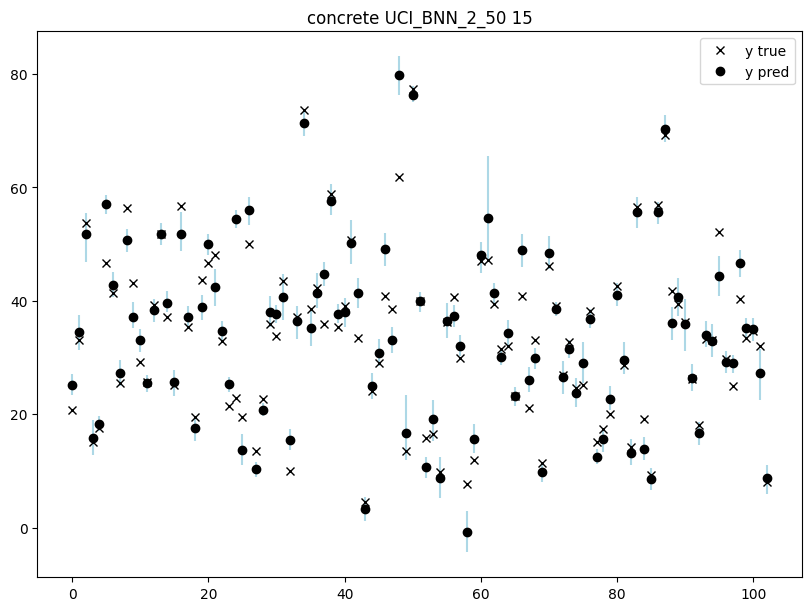

In [16]:
from matplotlib.collections import LineCollection
#fig, axs = plt.subplots(1, len(models), figsize=(8, 6*len(models)), constrained_layout=True)
#axs = axs.ravel()
for i, d in enumerate(models):
    if i % 5 != 0:
        continue
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    ax.set_title(f"{d['dataset']} {d['model']} {d['split']}")

    X = dataset.normalize_X(dataset.data[:, :-1], split)
    y = dataset.data[:, -1]

    train_X = X[split["tr"]]
    train_y = y[split["tr"]]
    test_X = X[split["te"]]
    test_y = y[split["te"]]

    predictive = Predictive(bnns.model_configs.__dict__[d["model"]], posterior_samples=d["samples"], return_sites=["y", "y_loc"], batch_ndims=2)
    key = jax.random.PRNGKey(SEED)
    predictive_ys = predictive(key, X=test_X, y=None, D_Y=1)["y_loc"]

    rmse = jnp.sqrt(jnp.mean((predictive_ys[0,:,:,0].mean(0) - test_y) ** 2))
    percentiles = np.percentile(predictive_ys[0,:,:,0], [5, 95], axis=0)
    ran = np.arange(predictive_ys.shape[1])
    ax.add_collection(
        LineCollection(
            zip(zip(ran, percentiles[0]), zip(ran, percentiles[1])), colors="lightblue"
        )
    )
    nll = -log_likelihood(bnns.model_configs.__dict__[d['model']], d['samples'], X=test_X, y=test_y, batch_ndims=2)['y'].mean()
    print(f"DATASET: {d['dataset']}, SPLIT: {d['split']}, NLL: {nll}, RMSE: {rmse}")
    ax.plot(test_y, "kx", label="y true")
    predictive_ys = predictive(key, X=test_X, y=None, D_Y=1)["y"]
    ax.plot(predictive_ys[0].mean(0)[:,0], "ko", label="y pred")
    ax.legend()


In [39]:
import dill
from numpyro import sample, plate, deterministic
from numpyro.distributions import Normal, Gamma
import numpyro.distributions as dist
from jax import nn

def BNN(X, y=None, depth=1, width=4, sigma=1.0, D_Y=None, activation=jnp.tanh):
    # Make sure D_Y is defined
    if y is None and D_Y is None:
        raise ValueError("Either y or D_Y must be provided.")
    if y is not None:
        if y.ndim == 1:
            y = y[..., None]
        D_Y = y.shape[-1]

    N = X.shape[-2]
    D_X = X.shape[-1]
    D_Z = width
    if depth == 1:
        D_Z = D_Y

    # First layer
    w = numpyro.sample("w0", dist.Normal(0.0, 1).expand((D_X, D_Z)))
    b = numpyro.sample("b0", dist.Normal(0.0, 1).expand((D_Z, )))
    z = X @ w + b.flatten()
    z_p = activation(z)

    # Middle layers:
    for i in range(1, depth):
        w = numpyro.sample(f"w{i}", dist.Normal(0.0, 1).expand((D_Z, D_Z)))
        b = numpyro.sample(f"b{i}", dist.Normal(0.0, 1).expand((D_Z,)))
        z = z_p @ w + b
        z_p = activation(z)

    # Last layer
    w = numpyro.sample(f"w{depth}", dist.Normal(0.0, 1).expand((D_Z,D_Y)))
    b = numpyro.sample(f"b{depth}", dist.Normal(0.0, 1).expand((D_Y,)))
    z = (z_p @ w + b).reshape(-1,1)
    if y is not None:
        assert z.shape == y.shape
    else:
        assert z.shape[-1] == D_Y
    with numpyro.plate("data", N):
        y_loc = deterministic("y_loc", z)
        numpyro.sample("y", dist.Normal(y_loc, sigma).to_event(1), obs=y)

def UCI_BNN(X, y=None, depth=2, width=50, D_Y=None):
    prec = numpyro.sample("prec", dist.Gamma(1.0, 0.1))
    _sigma = jnp.sqrt(1 / prec)
    BNN(X, y, depth=depth, width=width, D_Y=D_Y, sigma=_sigma, activation=nn.relu)

def smi_model(x, y):
    """BNN described in appendix D of [1]

    **References:**
        1. Understanding the Variance Collapse of SVGD in High Dimensions
           Jimmy Ba, Murat A. Erdogdu, Marzyeh Ghassemi, Shengyang Sun, Taiji Suzuki, Denny Wu, Tianzong Zhang
    """

    hdim = 50  # Hidden dimension is fixed

    prec = sample("prec", Gamma(1.0, 0.1))

    w1 = sample(
        "w1",
        Normal(0.0, 1).expand(
            (
                x.shape[1] if len(x.shape) > 1 else 1,
                hdim,
            )
        ),
    )  # prior on l1 weights
    b1 = sample("b1", Normal(0.0, 1).expand((hdim,)))  # prior on output bias term

    w2 = sample("w2", Normal(0.0, 1).expand((hdim, hdim)))  # prior on l1 weights
    b2 = sample("b2", Normal(0.0, 1).expand((hdim,)))  # prior on output bias term

    w3 = sample("w3", Normal(0.0, 1).expand((hdim,)))  # prior on output weights

    b3 = sample("b3", Normal(0.0, 1))  # prior on output bias term

    with plate(
        "data",
        x.shape[0],
    ) as idx:
        x_batch = x
        y_batch = y
        # 1 hidden layer with relu activation
        y_loc_p = nn.relu(nn.relu(x_batch @ w1 + b1) @ w2 + b2) @ w3 + b3
        y_loc = deterministic(
            "y_loc", y_loc_p
        )
        sample(
            "y",
            Normal(y_loc, jnp.sqrt(1 / prec)),
            obs=y_batch,
        )

smi_sample_path = "../samples/2025-02-12T15:31:49.515586"
model = lambda x, y: UCI_BNN(X=x, y=y, D_Y=1)
dataset = UCIDataset("boston-housing")
split = load_standard_splits(True)["boston-housing"][0]
with open(os.path.join(smi_sample_path, "boston-housing/bnn/nuts/none/artifact", "0.dill"), "rb") as f:
    artifact = dill.load(f)
samples = artifact["post_draws"]
X = dataset.normalize_X(dataset.data[:, :-1], split)
y = dataset.y
for i in range(3):
    samples[f"w{i}"] = samples.pop(f"w{i+1}")
    samples[f"b{i}"] = samples.pop(f"b{i+1}")

print("NLL ", -log_likelihood(model, samples, X[split["te"]], y[split["te"]], batch_ndims=2)["y"].mean())

def rmse_fn(posterior_samples, y, batch_ndims):
    """Compute the root mean squared error"""

    y_pred = posterior_samples["y_loc"]
    return jnp.sqrt(((y[None] - y_pred) ** 2).mean())

train_y_loc = samples.pop("y_loc", None)
assert train_y_loc is not None
predictive = Predictive(model, posterior_samples=samples, return_sites=["y", "y_loc"], batch_ndims=2)
key = jax.random.PRNGKey(SEED)
predicted_ys = predictive(key, X[split["te"]], None)["y_loc"]
rmse = rmse_fn({"y_loc": predicted_ys}, y[split["te"]], batch_ndims=2)
print("RMSE ", rmse)
# predictive = Predictive(model, posterior_samples=samples, return_sites=["y"], batch_ndims=2, parallel=True)
# pred_train_y = predictive(key, X=X[split["tr"]], y=None, D_Y=1)["y"]
# pred_test_y = predictive(key, X=X[split["te"]], y=None, D_Y=1)["y"]

NLL  16190.829
RMSE  10.491224


     model_name   key    ess-mean   ess-top-5  ess-bottom-5  rhat-mean  \
0  UCI_BNN_2_50    b0   87.325524  131.832389     49.078960   1.011531   
1  UCI_BNN_2_50    b1  298.884470  513.233370    123.777447   1.004666   
2  UCI_BNN_2_50    b2  317.618507  317.618507    317.618507   1.000087   
3  UCI_BNN_2_50  prec   38.848035   38.848035     38.848035   1.001337   
4  UCI_BNN_2_50    w0  137.789906  225.306717     65.416546   1.008429   
5  UCI_BNN_2_50    w1  242.168463  406.692881    119.482590   1.004901   
6  UCI_BNN_2_50    w2   38.120011   95.778420      5.611179   1.074893   

   rhat-top-5  rhat-bottom-5  
0    1.046664       0.999684  
1    1.018626       0.999683  
2    1.000087       1.000087  
3    1.001337       1.001337  
4    1.034023       0.999716  
5    1.021083       0.999682  
6    1.258877       0.999957  
     model_name   key    ess-mean   ess-top-5  ess-bottom-5  rhat-mean  \
0  UCI_BNN_2_50    b0  105.568498  174.216095     52.449839   1.008044   
1  UCI_BNN_

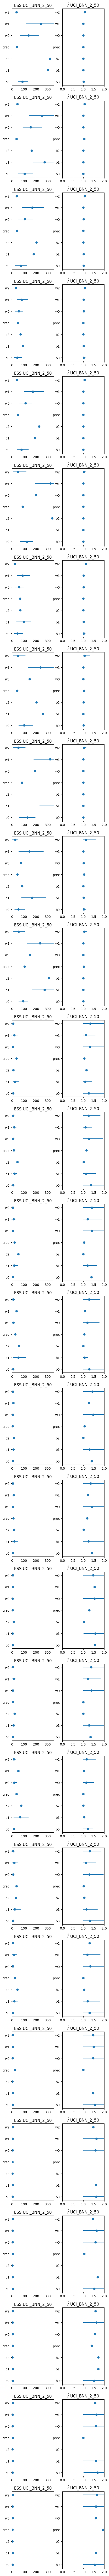

In [35]:
fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(5, 5*len(models)))
for i, model in enumerate(models):
    az_data = model["az_data"]
    keys = model["samples"].keys()
    # ess = az.ess(az_data)
    data = []
    for key in keys:
        rhat = numpyro.diagnostics.split_gelman_rubin(model["samples"][key])
        ess = numpyro.diagnostics.effective_sample_size(model["samples"][key])
        data.append({
            "model_name": model["model"],
            "key": str(key),
            "ess-mean": ess.mean(),
            "ess-top-5": np.percentile(ess,95),
            "ess-bottom-5": np.percentile(ess,5),
            "rhat-mean": rhat.mean(),
            "rhat-top-5": np.percentile(rhat, 95),
            "rhat-bottom-5": np.percentile(rhat, 5),
        })
    df = pd.DataFrame(data)
    # axs[i, 0].plot(df["ess-mean"], df["key"], "ko", label="mean")
    axs[i, 0].errorbar(df["ess-mean"], df["key"], xerr=[df["ess-mean"] - df["ess-bottom-5"], df["ess-top-5"] - df["ess-mean"]], fmt="o")
    axs[i, 0].set_title(f"ESS {model["model"]}")
    axs[i, 0].set_xlim([0,350])

    # axs[i, 1].plot(df["rhat-mean"], df["key"], "ko", label="mean")
    axs[i, 1].set_xlim([0,2])
    axs[i, 1].errorbar(df["rhat-mean"], df["key"], xerr=[df["rhat-mean"] - df["rhat-bottom-5"], df["rhat-top-5"] - df["rhat-mean"]], fmt="o")
    axs[i, 1].set_title(f"{r"$\hat{r}$"} {model["model"]}")
    print(df)
#sns.lineplot(data=df, x="mean", y="key", hue="model_name", dodge=True)



In [105]:
ess.data_vars["b0"].mean()

<xarray.DataArray 'b0' ()> Size: 8B
array(20.32781263)

{'model': None,
 'guide': None,
 'params': None,
 'hyper_params': {'lr': None},
 'post_draws': {'prec': Array([[0.47007948, 0.47976005, 0.47588268, ..., 0.42138174, 0.42835027,
          0.42088836]], dtype=float32),
  'y_loc': Array([[[30.557629 , 23.540201 , 16.544842 , ..., 19.854206 ,
           13.306897 , 22.948927 ],
          [27.71121  , 24.874876 , 17.373001 , ..., 20.129562 ,
           13.991251 , 21.442116 ],
          [29.588762 , 25.360512 , 18.586535 , ..., 20.604664 ,
           13.444028 , 21.29989  ],
          ...,
          [27.948448 , 24.540367 , 19.078539 , ..., 19.65227  ,
           13.37832  , 21.840698 ],
          [29.802168 , 24.389034 , 20.482634 , ..., 19.19399  ,
           13.1453085, 22.23238  ],
          [30.339603 , 24.072792 , 19.382608 , ..., 19.739878 ,
           14.361593 , 22.001156 ]]], dtype=float32),
  'w0': Array([[[[-1.4972149 , -0.240414  , -1.3065985 , ...,  1.0526959 ,
             0.41472426, -1.2383453 ],
           [ 0.28218284,  0

# MCMC diagnostics

## Load metadata

In [11]:
from jax.numpy import float32, int32 , array as Array
import dill
metadatas = []
for dataset_name in os.listdir(SAMPLE_PATH):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-13:] == "metadata.dill":
                with open(os.path.join(SAMPLE_PATH, dataset_name, file_name), "rb") as f:
                    metadatas.append(dill.load(f))
metadatas

[{'accept_prob': Array([0.44642743, 0.5087748 , 0.60724276, ..., 0.7188942 , 0.38208443,
         0.8231239 ], dtype=float32),
  'adapt_state.step_size': Array([0.00140091, 0.00140091, 0.00140091, ..., 0.00140091, 0.00140091,
         0.00140091], dtype=float32),
  'diverging': Array([False, False, False, ..., False, False, False], dtype=bool),
  'i': Array([ 501,  502,  503, ..., 3498, 3499, 3500], dtype=int32),
  'mean_accept_prob': Array([0.44642743, 0.4776011 , 0.520815  , ..., 0.7419791 , 0.74185914,
         0.7418862 ], dtype=float32),
  'num_steps': Array([1023, 1023, 1023, ..., 1023, 1023, 1023], dtype=int32),
  'time_spanned': 1178.5051238536835},
 {'accept_prob': Array([0.97864485, 0.9597556 , 0.9435261 , ..., 0.78462887, 0.87627894,
         0.78704566], dtype=float32),
  'adapt_state.step_size': Array([0.00103738, 0.00103738, 0.00103738, ..., 0.00103738, 0.00103738,
         0.00103738], dtype=float32),
  'diverging': Array([False, False, False, ..., False, False, False], 

# Acceptance probability

In [12]:
import seaborn as sns
fig, axs = plt.subplots(len(metadatas), 1, figsize=(15, 5*len(metadatas)))
axs = np.array([axs]) if len(metadatas) == 1 else axs
for metadata, ax in zip(metadatas, axs):
    data = pd.DataFrame(metadata)
    sns.lineplot(data=data, x="i", y="mean_accept_prob", ax=ax)

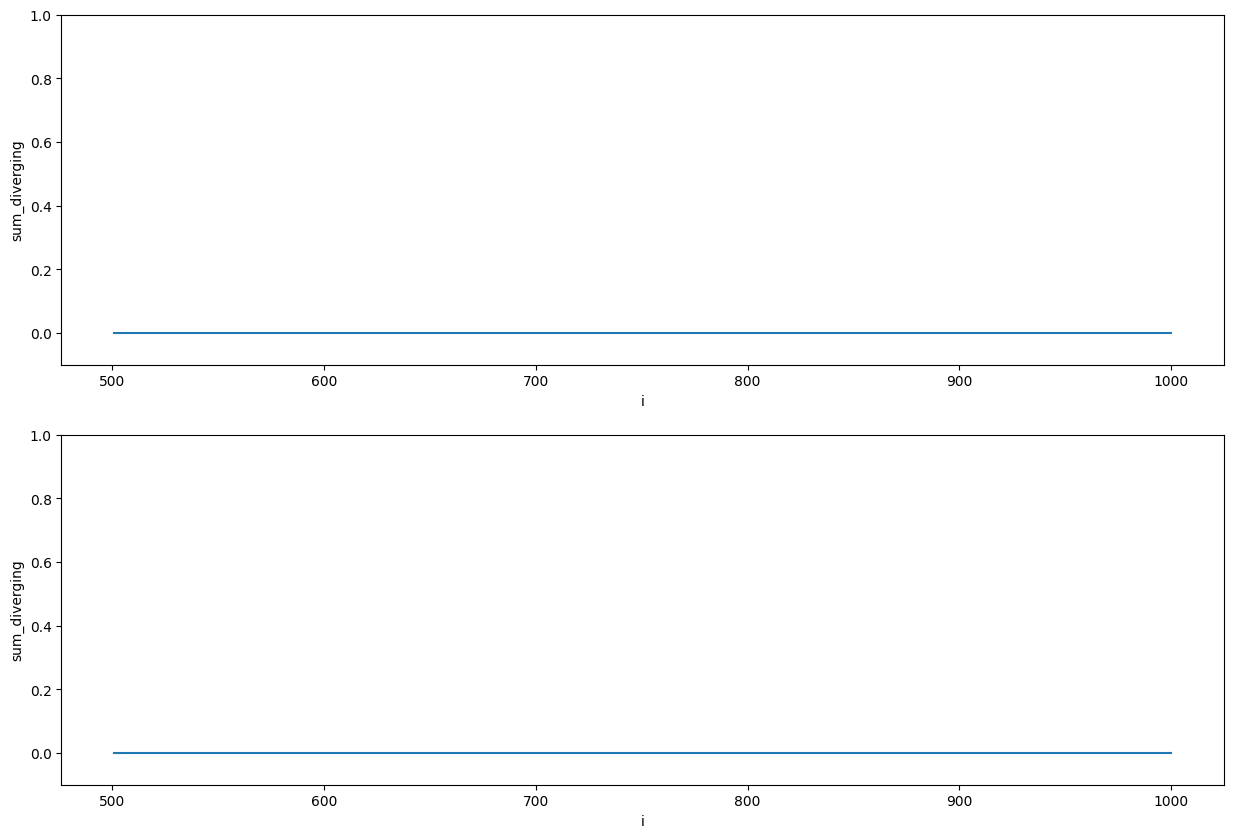

In [170]:
fig, axs = plt.subplots(len(metadatas), 1, figsize=(15, 5*len(metadatas)))
axs = np.array([axs]) if len(metadatas) == 1 else axs
for metadata, ax in zip(metadatas, axs):
    data = pd.DataFrame(metadata)
    data["sum_diverging"] = data["diverging"].cumsum()
    sns.lineplot(data=data, x="i", y="sum_diverging", ax=ax)
    ax.set_ylim([-0.1,1])

<Axes: xlabel='model_name', ylabel='time_spanned'>

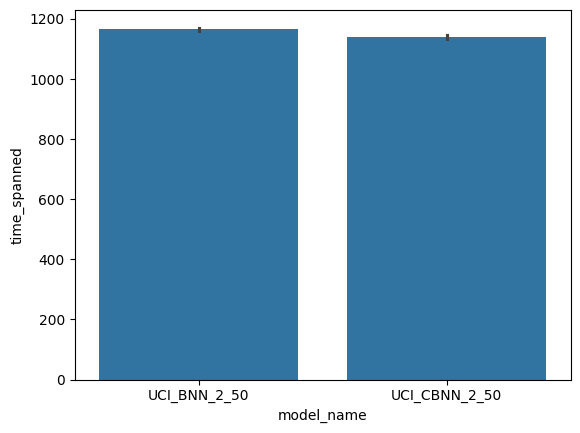

In [14]:
total_df = []
for i, metadata in enumerate(metadatas):
    metadata["model_name"] = models[i]["model"]
    total_df.append(metadata)
total_df = pd.DataFrame(total_df)
sns.barplot(data=total_df, x="model_name", y="time_spanned")

<Axes: xlabel='model', ylabel='prec'>

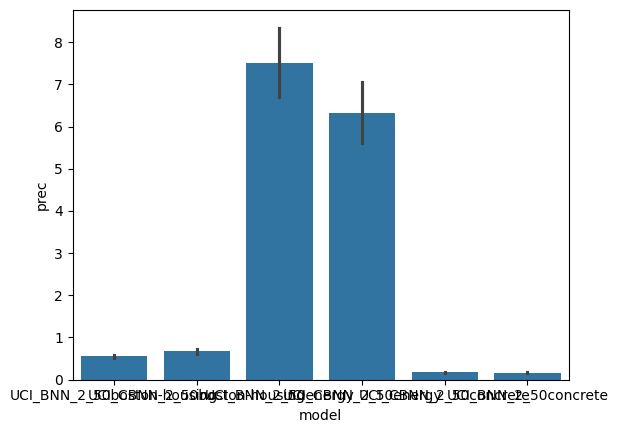

In [14]:
total_df = []
for model in models:
    total_df.append({"model": model["model"] + model["dataset"], "prec": model["samples"]["prec"].mean()})

sns.barplot(data=pd.DataFrame(total_df), x="model", y="prec")

In [15]:
jnp.sqrt(1/0.5)

Array(1.4142135, dtype=float32, weak_type=True)

# Precision prior vs posterior

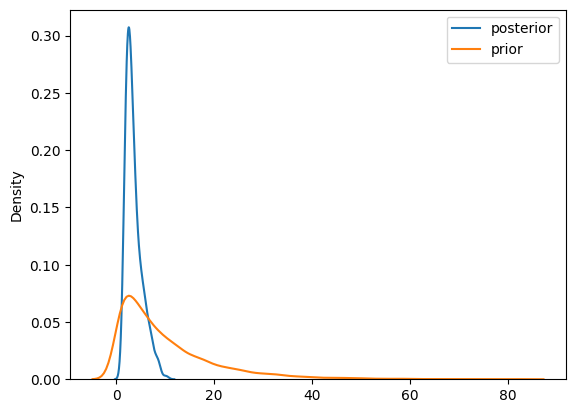

In [26]:
sns.kdeplot(data=d["samples"]["prec"].flatten(), label="posterior")
sns.kdeplot(jax.random.gamma(jax.random.PRNGKey(SEED), 1.0, (10000,))/0.1, label="prior")
plt.legend()